# 1.Input data

In [2]:
airportsDF = spark.read.load("/data/students/bigdata_internet/lab5/airports.csv",
                        format="csv",
                        header=True,
                        inferSchema=True)
airlinesDF = spark.read.load("/data/students/bigdata_internet/lab5/airlines.csv",
                        format="csv",
                        header=True,
                        inferSchema=True)
routesDF = spark.read.load("/data/students/bigdata_internet/lab5/routes.csv",
                        format="csv",
                        header=True,
                        inferSchema=True).filter("airline_id!=-1")

# 2.Top airports and airlines

In [13]:
print("Task 1: ")
airportsDF.select("country").groupBy("country").count().filter("count>100")\
            .sort("count",ascending=False).show()

print("Task 2: ")
topAirlineDF = routesDF.select("airline_id").groupBy("airline_id").count()\
                        .sort("count",ascending=False).limit(15)
topAirlineDF.join(airlinesDF,topAirlineDF.airline_id==airlinesDF.airline_id)\
            .select("name","icao","count").show()

print("Task 3: ")
topRouteDF= routesDF.select("airport_source_id","airport_destination_id")\
                    .groupBy("airport_source_id","airport_destination_id")\
                    .count().sort("count",ascending=False).limit(15)
topRouteDFMatchSource = topRouteDF.join(airportsDF,
                        topRouteDF.airport_source_id==airportsDF.id)\
                        .selectExpr("name AS source_airport_name",
                                    "city AS source_airport_city",
                                    "airport_destination_id","count")
topRouteDFMatchAll = topRouteDFMatchSource.join(airportsDF,
                    topRouteDFMatchSource.airport_destination_id==airportsDF.id)\
                    .selectExpr("source_airport_name","source_airport_city",
                                "name AS destination_airport_name",
                                "city AS desitination_airport_city","count")\
                    .sort("count",ascending=False)
topRouteDFMatchAll.show()

Task 1: 
+--------------+-----+
|       country|count|
+--------------+-----+
| United States| 1512|
|        Canada|  430|
|     Australia|  334|
|        Brazil|  264|
|        Russia|  264|
|       Germany|  249|
|         China|  241|
|        France|  217|
|United Kingdom|  167|
|         India|  148|
|     Indonesia|  145|
|         Japan|  123|
+--------------+-----+

Task 2: 
+--------------------+----+-----+
|                name|icao|count|
+--------------------+----+-----+
|   American Airlines| AAL| 2354|
|          Air France| AFR| 1071|
|            Alitalia| AZA|  877|
|           Air China| CCA| 1260|
|China Eastern Air...| CES| 1263|
|China Southern Ai...| CSN| 1454|
|     Delta Air Lines| DAL| 1981|
|             easyJet| EZY| 1130|
|     Iberia Airlines| IBE|  831|
|KLM Royal Dutch A...| KLM|  830|
|           Lufthansa| DLH|  923|
|             Ryanair| RYR| 2484|
|  Southwest Airlines| SWA| 1146|
|     United Airlines| UAL| 2180|
|          US Airways| USA| 1960|
+

# 3.Create the graph of flight connections

In [4]:
filtedRoutesDF= routesDF.filter("airport_source_id != '\\\\N' and airport_destination_id!='\\\\N'")
airportsDF=airportsDF.withColumn("id",airportsDF.id.cast("string"))
filtedRoutesDF=filtedRoutesDF.withColumnRenamed("airport_source_id","src")\
                                .withColumnRenamed("airport_destination_id","dst")

In [5]:
from graphframes import GraphFrame
g = GraphFrame(airportsDF, filtedRoutesDF)

# 4.Analyze and process the graph

## Task 1

In [6]:
print("Outdegrees:")
outDegree = g.outDegrees.sort("outDegree",ascending = False).limit(15)
outDegree.join(airportsDF,"id").select("name","id","outDegree").sort("outDegree",ascending=False).show()

print("Indegrees: ")
inDegree = g.inDegrees.sort("inDegree",ascending=False).limit(15)
inDegree.join(airportsDF,"id").select("name","id","inDegree").sort("inDegree",ascending=False).show()

Outdegrees:
+--------------------+----+---------+
|                name|  id|outDegree|
+--------------------+----+---------+
|Hartsfield Jackso...|3682|      915|
|Chicago O'Hare In...|3830|      558|
|Beijing Capital I...|3364|      535|
|London Heathrow A...| 507|      525|
|Charles de Gaulle...|1382|      524|
|Frankfurt am Main...| 340|      497|
|Los Angeles Inter...|3484|      492|
|Dallas Fort Worth...|3670|      469|
|John F Kennedy In...|3797|      456|
|Amsterdam Airport...| 580|      453|
|Shanghai Pudong I...|3406|      411|
|Singapore Changi ...|3316|      405|
|Barcelona Interna...|1218|      391|
|Incheon Internati...|3930|      370|
|Miami Internation...|3576|      368|
+--------------------+----+---------+

Indegrees: 
+--------------------+----+--------+
|                name|  id|inDegree|
+--------------------+----+--------+
|Hartsfield Jackso...|3682|     911|
|Chicago O'Hare In...|3830|     550|
|Beijing Capital I...|3364|     534|
|London Heathrow A...| 507|    

## Task 2

In [7]:
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf
chain1 = g.find("(a)-[ab]->(b)")
chain2 = g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
chain3 = g.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[cd]->(d)")
def condition(a):
    return (a["id"] == "1526")
    
conditionUDF = udf(condition,BooleanType())
chainWith1Flight = chain1.filter(conditionUDF(chain1.a))
print("Number of reachable airports form Turin taking exactly 1 flight:",chainWith1Flight.select("b")\
      .distinct().count())

chainWith2Flight = chain2.filter(conditionUDF(chain2.a))
print("Number of reachable airports form Turin taking exactly 2 flight:",chainWith2Flight.select("c")\
      .distinct().count())

chainWith3Flight = chain3.filter(conditionUDF(chain3.a))
print("Number of reachable airports form Turin taking exactly 3 flight:",chainWith3Flight.select("d")\
      .distinct().count())


Number of reachable airports form Turin taking exactly 1 flight: 29
Number of reachable airports form Turin taking exactly 2 flight: 590
Number of reachable airports form Turin taking exactly 3 flight: 2192


## Task 3

In [8]:
shortestPathDF = g.shortestPaths(landmarks = ["1526"])
def calHops(dist):
    val = dist.get("1526")
    return val
spark.udf.register("calHops",calHops)
shortestPathDF.selectExpr("name","city","country","calHops(distances) AS hops")\
                .sort("hops",ascending=False).show(12)

+--------------------+--------------------+-------------+----+
|                name|                city|      country|hops|
+--------------------+--------------------+-------------+----+
|    Portland Airport|            Portland|    Australia|   7|
|      Thule Air Base|               Thule|    Greenland|   7|
|   Nightmute Airport|           Nightmute|United States|   7|
|Lourdes de Blanc ...|Lourdes-De-Blanc-...|       Canada|   7|
|Thargomindah Airport|        Thargomindah|    Australia|   7|
|    Hopedale Airport|            Hopedale|       Canada|   7|
|  Birdsville Airport|          Birdsville|    Australia|   7|
|La Tabatière Airport|        La Tabatière|       Canada|   7|
|      Futuna Airport|       Futuna Island|      Vanuatu|   6|
|    Windorah Airport|            Windorah|    Australia|   6|
|   Mota Lava Airport|               Ablow|      Vanuatu|   6|
|Arctic Village Ai...|      Arctic Village|United States|   6|
+--------------------+--------------------+------------

## Task 4

In [9]:
idOfPuerto=airportsDF.filter("city=='Puerto Montt'").take(1)[0].id
shortestToTwo= g.shortestPaths(landmarks = ["1526",idOfPuerto])

def compareCondition1(dist):
    if dist.get("1526")==None or dist.get(idOfPuerto)==None:
        return False
    return dist.get("1526")<dist.get(idOfPuerto)
compareCondition1UDF=udf(compareCondition1,BooleanType())

def compareCondition2(dist):
    if dist.get("1526")==None or dist.get(idOfPuerto)==None:
        return False
    return dist.get("1526")>dist.get(idOfPuerto)
compareCondition2UDF=udf(compareCondition2,BooleanType())

def compareCondition3(dist):
    if dist.get("1526")==None or dist.get(idOfPuerto)==None:
        return False
    return dist.get("1526")==dist.get(idOfPuerto)
compareCondition3UDF=udf(compareCondition3,BooleanType())

print("Number of airports in the world you can reach Turin using less hops than to reach Puerto Montt: ",
     shortestToTwo.filter(compareCondition1UDF(shortestToTwo.distances)).count())
print("Number of airports in the world you can reach Puerto Montt using less hops than to reach Turin: ",
     shortestToTwo.filter(compareCondition2UDF(shortestToTwo.distances)).count())
print("Number of airports in the world d you can reach with the same number of hops Turin and Puerto Montt: ",
     shortestToTwo.filter(compareCondition3UDF(shortestToTwo.distances)).count())

Number of airports in the world you can reach Turin using less hops than to reach Puerto Montt:  2130
Number of airports in the world you can reach Puerto Montt using less hops than to reach Turin:  143
Number of airports in the world d you can reach with the same number of hops Turin and Puerto Montt:  820


## Task 5

In [10]:
g2=g.dropIsolatedVertices()
sc.setCheckpointDir("tmp_ckpts")
connComp=g2.connectedComponents()
print("The number of connected components of at least two airport is: ",connComp.select("component")\
      .groupBy("component").count().filter("count>1").count())
print("The size of each component is: ")
connComp.select("component").groupBy("component").count().filter("count>1").show()

The number of connected components of at least two airport is:  7
The size of each component is: 
+-------------+-----+
|    component|count|
+-------------+-----+
|            0| 3111|
|            9|    4|
| 721554505735|    2|
| 266287972363|    4|
| 300647710722|   10|
| 352187318278|    4|
|1460288880648|    2|
+-------------+-----+



## Task 6

In [11]:
# To find the airline involving in at least 6 cities and show the number of flights of each of these airline
flightMapAirlineDF=filtedRoutesDF.join(airlinesDF,"airline_id")
flightIcaoSrc =flightMapAirlineDF.select("icao","src")
airportsSimpleDF=airportsDF.select("id","city")
icaoMapSrcCityDF = flightIcaoSrc.join(airportsSimpleDF,flightIcaoSrc.src==airportsSimpleDF.id)\
                                .selectExpr("id","icao","city AS srcCity")
icaoCityNumDF = icaoMapSrcCityDF.distinct().groupBy("icao").count().filter("count>=6")\
                                .selectExpr("icao","count AS cityCount")
icaoFlightNumDF =flightMapAirlineDF.groupBy("icao").count().selectExpr("icao","count AS flightCount")
statisticDF = icaoCityNumDF.join(icaoFlightNumDF,"icao").filter("flightCount>10 and flightCount<15")
statisticDF.show(5)

+----+---------+-----------+
|icao|cityCount|flightCount|
+----+---------+-----------+
| RAR|        7|         13|
| TCF|       12|         14|
| WER|        7|         12|
| VNP|        7|         12|
| OAW|        9|         14|
+----+---------+-----------+
only showing top 5 rows



Choose airlines with icao RAR and OAW to build the Subgraph


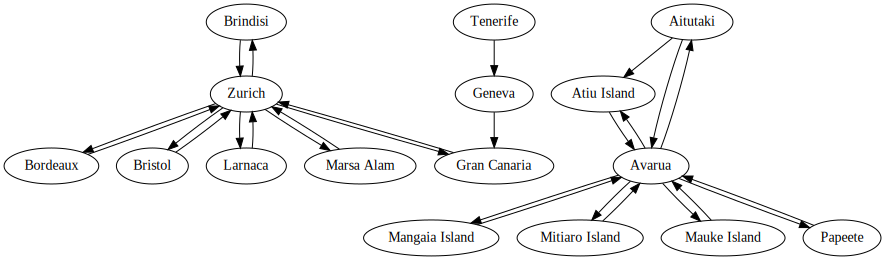

In [12]:
print("Choose airlines with icao RAR and OAW to build the Subgraph")
newEdges = flightMapAirlineDF.filter("icao=='RAR' or icao=='OAW'")
gSub =  GraphFrame(airportsDF, newEdges).dropIsolatedVertices()
from graphviz import Digraph
def vizGraph(edge_list,node_list):
    Gplot=Digraph()
    edges=edge_list.collect()
    nodes=node_list.collect()
    for row in edges:
        Gplot.edge(row['src'],row['dst'])
    for row in nodes:
        Gplot.node(row['id'],label=row['city'])
    return Gplot
Gplot=vizGraph(gSub.edges,gSub.vertices)
Gplot

# 5.Bonus Task

In [17]:
import math
def distanceBetweenTwo(lat1,long1,lat2,long2):
    toRad = 0.01745329252
    lat1 = lat1*toRad
    long1 =long1*toRad
    lat2=lat2*toRad
    long2=long2*toRad
    r = 6356.725 # km
    temp1 =math.sin((lat2-lat1)/2)*math.sin((lat2-lat1)/2)
    temp2 = math.cos(lat1)*math.cos(lat2)*math.sin((long2-long1)/2)*math.sin((long2-long1)/2)
    return 2*r*math.asin(math.sqrt(temp1+temp2)) 

def calTotalDistance(lat1,long1,lat2,long2,lat3,long3):
    dist1=distanceBetweenTwo(lat1,long1,lat2,long2)
    dist2=distanceBetweenTwo(lat2,long2,lat3,long3)
    return float(dist1)+float(dist2)
spark.udf.register("distanceCal",calTotalDistance)


<function __main__.calTotalDistance(lat1, long1, lat2, long2, lat3, long3)>

In [26]:
idOfTancredo=airportsDF.filter("city=='Belo Horizonte' and name=='Tancredo Neves International Airport'")\
                        .take(1)[0].id

chainTancredo = g.find("(a)-[ab]->(b); (b)-[bc]->(c)")
def condition2(a,c):
    return (a["id"] == idOfTancredo and c["id"]!=a["id"])
condition2UDF = udf(condition2,BooleanType())


chainTancredoDF = chain2.filter(condition2UDF(chain2.a,chain2.c))
chainDistDF = chainTancredoDF.selectExpr("a.name AS src","b.name AS mid","c.name AS dst",
            "distanceCal(a.latitude,a.longitude,b.latitude,b.longitude,c.latitude,c.longitude) AS distance")
print("The maximum total distance you can flight taking exactly two fligths from Tancredo Neves International Airport is:")
chainDistDF=chainDistDF.withColumn("distance",chainDistDF.distance.cast("float"))
chainDistDF.sort("distance",ascending=False).show(1,False)

The maximum total distance you can flight taking exactly two fligths from Tancredo Neves International Airport is:
+------------------------------------+-------------------------------------------------+---------------------+---------+
|src                                 |mid                                              |dst                  |distance |
+------------------------------------+-------------------------------------------------+---------------------+---------+
|Tancredo Neves International Airport|Humberto Delgado Airport (Lisbon Portela Airport)|Salgado Filho Airport|16203.224|
+------------------------------------+-------------------------------------------------+---------------------+---------+
only showing top 1 row



Answer:  the maximum total distance you can flight taking exactly two fligths from "Tancredo Neves International Airport" is 16203.224 km